In [1]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "============"*8 + "%s"%nowtime)

In [2]:
printbar()


================================================================================================2021-01-28 10:33:58


在Pytorch中构建图片数据管道通常有两种方法。

1. 使用torchvision中的datasets.ImageFolder来读取图片然后使用DataLoader来并行加载。
2. 通过继承torch.utils.data.Dataset实现用户自定义读取逻辑然后用DataLoader来并行加载。
3. 通过读取用户自定义数据集的用用方法，即可以读取图片数据集，也可以读取文本数据集。

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,datasets

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_valid = transforms.Compose([transforms.ToTensor()])

In [5]:
'''
ImageFolder假设所有的文件按文件夹保存，每个文件夹下存储同一个类别的图片，文件夹名为类名。
'''
ds_train = datasets.ImageFolder("./cifar2/train",
                                transform=transform_train,                                                                                 target_transform=lambda t: torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./cifar2/test",
                                transform=transform_valid,
                                target_transform=lambda t: torch.tensor([t]).float())
'''
label是按照文件夹名顺序排序后存成字典，即{类名:类序号(从0开始)}，一般来说最好直接将文件夹命名为从0开始的数字，
这样会和ImageFolder实际的label一致，如果不是这种命名规范，建议看看self.class_to_idx属性以了解label和文件夹名的映射关系。
'''
print(ds_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


In [6]:
dl_train = DataLoader(ds_train, batch_size=50, shuffle=True, num_workers=3)
dl_valid = DataLoader(ds_valid, batch_size=50, shuffle=True, num_workers=3)

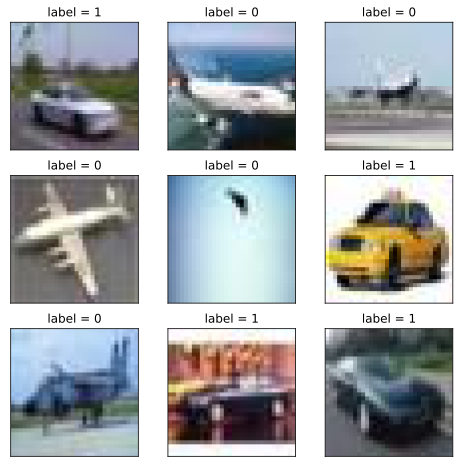

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
import random

plt.figure(figsize=(8,8))
for i in range(9):
    index = random.randint(0,9999)
    img, label = ds_train[index]
    img = img.permute(1, 2, 0)
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [8]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height
for x,y in dl_train:
    print(x.shape,y.shape) 
    break

torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


## 二、定义模型

使用Pytorch通常有三种方式构建模型：
- 使用nn.Sequential按层顺序构建模型;
- 继承nn.Module基类构建自定义模型;
- 继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择通过继承nn.Module基类构建自定义模型。

In [9]:
#测试AdaptiveMaxPool2d的效果
pool = nn.AdaptiveMaxPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape 

torch.Size([10, 8, 1, 1])

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [11]:
import torchkeras
torchkeras.summary(net,input_shape= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.011719
Forwar

## 三、训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处用一种较通用的函数形式训练循环。

In [12]:
import pandas as pd
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred,y_true: roc_auc_score(y_true.data.numpy(), y_pred.data.numpy())
model.metric_name = "auc"

In [13]:
def train_step(model,features,labels):

    # 训练模式，dropout发生作用
    model.train()

    # 梯度清零
    model.optimizer.zero_grad()

    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions,labels)

    # 反向传播
    loss.backward()
    model.optimizer.step()

    #损失函数
    return loss.item(), metric.item()

def valid_step(model,features,labels):

    # 测试模式
    model.eval()

    # 关闭梯度计算
    with torch.no_grad():
        predictions = model(features)
        loss = model.loss_func(predictions, labels)
        metric = model.metric_func(predictions, labels)
    
    return loss.item(), metric.item()

In [14]:
features_and_labels = next(iter(dl_train))
train_step(model, features_and_labels[0], features_and_labels[1])

(0.7032064199447632, 0.4711538461538462)

In [15]:
enumerate(dl_train, 1)

In [30]:
def train_model(model, epochs, dl_train, dl_valid, log_step_freq):
    
    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_" + metric_name])
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("========"*8 + "%s"%nowtime)

    for epoch in range(1, epochs+1):

        # 1.训练循环                
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features, labels) in enumerate(dl_train, 1):

            loss, metric = train_step(model, features, labels)

            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:
                print( ("[step = %d] loss:%.3f, " + metric_name + ":%.3f")%(step, loss_sum/step, metric_sum/step))
        
        # 2.验证循环
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features,labels) in enumerate(dl_valid, 1):
            
            val_loss,val_metric = valid_step(model, features, labels)
            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3.记录日志
        info = (epoch, loss_sum/step, metric_sum/step, 
                val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # 打印epoch级别的日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
               " = %.3f, val_loss = %.3f, " + "val_" + metric_name + " = %.3f")%info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("========"*8 + "%s"%nowtime)
    
    print("Finish Training...")

    return dfhistory

In [31]:
dfhistory = train_model(model, 20, dl_train, dl_valid, log_step_freq=50)

Start Training...
================================================================2021-01-28 10:40:32
[step = 50] loss:0.422, auc:0.900
[step = 100] loss:0.432, auc:0.899
[step = 150] loss:0.426, auc:0.901
[step = 200] loss:0.427, auc:0.901

EPOCH = 1, loss = 0.427,auc = 0.901, val_loss = 0.397, val_auc = 0.916
================================================================2021-01-28 10:40:35
[step = 50] loss:0.424, auc:0.905
[step = 100] loss:0.416, auc:0.907
[step = 150] loss:0.413, auc:0.910
[step = 200] loss:0.413, auc:0.909

EPOCH = 2, loss = 0.413,auc = 0.909, val_loss = 0.361, val_auc = 0.925
================================================================2021-01-28 10:40:38
[step = 50] loss:0.408, auc:0.906
[step = 100] loss:0.405, auc:0.910
[step = 150] loss:0.408, auc:0.909
[step = 200] loss:0.406, auc:0.913

EPOCH = 3, loss = 0.406,auc = 0.913, val_loss = 0.413, val_auc = 0.924
================================================================2021-01-28 10:40:40
[step = 50] l

In [32]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.427270,0.901065,0.396637,0.916155
1,2.0,0.413481,0.908525,0.360631,0.925439
2,3.0,0.405559,0.912730,0.413005,0.924204
3,4.0,0.390779,0.919932,0.359264,0.929713
4,5.0,0.395921,0.921141,0.336533,0.938046
5,6.0,0.380966,0.926505,0.342837,0.936269
6,7.0,0.372515,0.930928,0.352628,0.940711
7,8.0,0.357909,0.934557,0.317795,0.946837
8,9.0,0.347717,0.935749,0.302237,0.948326
9,10.0,0.344975,0.939098,0.318928,0.948914


In [33]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metric = dfhistory[metric]
    val_metric = dfhistory['val_' + metric]
    epochs = range(1, len(train_metric)+1)
    plt.plot(epochs, train_metric, 'bo--')
    plt.plot(epochs, val_metric, 'ro--')
    plt.title('Training and validation' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric,'val_' + metric])
    plt.show()

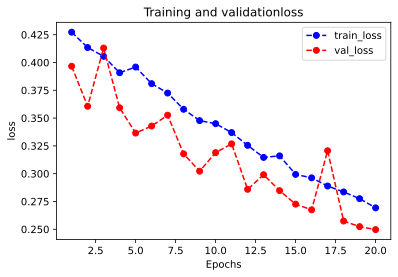

In [35]:
plot_metric(dfhistory, "loss")

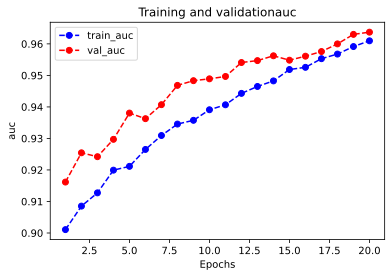

In [36]:
plot_metric(dfhistory, "auc")

## 5.使用模型

In [37]:
def predict(model, dl):
    model.eval()
    with torch.no_grad():
        result = torch.cat([model.forward(t[0]) for t in dl])
    return(result)

In [38]:
y_pred_probs = predict(model, dl_valid)
y_pred_probs

tensor([[0.8708],
        [0.0170],
        [0.0192],
        ...,
        [0.9545],
        [0.9650],
        [0.8372]])

In [39]:
y_pred = torch.where(y_pred_probs>0.5,
                    torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
y_pred

tensor([[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

## 6.保存模型

In [40]:
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])


In [42]:
# 保存模型参数
torch.save(model.state_dict(), "./data/model_parameter.pkl")

net_clone = Net()
net_clone.load_state_dict(torch.load("./data/model_parameter.pkl"))

predict(net_clone, dl_valid)

tensor([[0.0894],
        [0.9480],
        [0.0209],
        ...,
        [0.0218],
        [0.9086],
        [0.8868]])